***

* [Outline](../0_Introduction/0_introduction.ipynb)
* [Glossary](../0_Introduction/1_glossary.ipynb)
* 2. [Mathematical Background](2_0_introduction.ipynb)
    * Previous: [2.13 Spherical Trigonometry](2_13_sampling_theory.ipynb)
    * Next: [2.x Further Reading and References](2_x_further_reading_and_references.ipynb)

***

Import standard modules:

In [17]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
import scipy.signal as scg
%matplotlib inline
from ipywidgets import interact

## 2.14 Mathematics of the CLEAN algorithm

Here we give the mathematical details behind the implementation of the CLEAN algorithm. In particular we present deconvolution as an iterative $\chi^2$ minimisation of a linear system of equations. You should review the notation for linear systems given in [$\S$ 2.10.3 &#10142;](2_10_linear_algebra.ipynb). Although, by this stage, you should have the necessary mathematics to understand this section, it is meant to supplement the material given in [$\S$ 6 &#10142;](../6_Deconvolution) and is best read after you have become familiar with the basic concepts behind imaging and deconvolution. 

这里我们给出了CLEAN算法实现背后的数学细节。特别是我们现在反褶积作为迭代卡方$\chi^2$最小化一个线性方程组。你应该复习一下2.10.3中给出的线性系统的符号。虽然在这个阶段，您应该具备理解本节的必要数学知识，但它是对第6节中给出的材料的补充，最好在您熟悉成像和反褶积的基本概念之后阅读。

### 2.14.1 Imaging as an iterative $\chi^2$ minimisation problem

The imaging problem can be formulated as a linear system of the form成像问题可以表示为这种形式的线性系统
$$ S F I = V_{obs} + \epsilon, \quad \mbox{where} \quad \epsilon \sim \mathcal{N}(0,\Sigma).$$
Here $S$ is the sampling operator, $F$ the Direct Fourier transform and $I$ is the image we are after. The assumption that $\epsilon$ is Gaussian noise allows us to form the $\chi^2$ distribution as这里$S$是采样算子，$F$是直接傅里叶变换，$I$是我们要找的图像。假设$\epsilon$是高斯噪声，我们就可以得到$\chi^2$分布为

$$ \chi^2 = (S F I - V_{obs})^H W (S F I - V_{obs}), $$

where $W$ are the imaging weights. As already mentioned in $\S$ 2.10.3 (and elsewhere I am sure???), in interferometry, $W$ is not necessarily just the inverse of the covariance matrix $\Sigma^{-1}$. As will be demonstrated below the weights can actually be chosen to enhance certain desirable features in the image. For example, we could choose to implement uniform weighting which would down weight short baselines resulting in a sharper point spread function (denoted $I^{PSF}$) with smaller sidelobes. The downside of such a weighting scheme is that we lose signal to noise in the reconstructed dirty image (denoted $I^{D}$). We will give some examples below. For now our goal is to figure out how to find the image $I$ which minimises the $\chi^2$. Recall that this can be achieved by solving the normal equations. With the model as given above the gradient (also the Jacobian) is given by

其中$W$为成像权值。正如在$\S$ 2.10.3中已经提到的(我肯定在其他地方也提到过)，在干涉测量中，$W$不一定只是协方差矩阵$\Sigma^{-1}$的倒数。如下所示，权重实际上可以选择来增强图像中的某些理想特性。例如，我们可以选择实现统一的权重，这将降低权重的短基线，从而产生更清晰的点扩展函数(表示为$I^{PSF}$)和更小的旁瓣。这种加权方案的缺点是，我们在重构的脏图像(表示为$I^{D}$)中由于噪声而丢失了信号。我们将在下面给出一些例子。现在，我们的目标是找出如何找到使$\chi^2$最小化的图像$I$。回想一下，这可以通过解正规方程来实现。模型如上图所示，梯度(也是雅可比矩阵)由

$$ \partial_x \chi^2 = \mathbb{J}(I) = F^H S^H W (S F I - V_{obs}). $$

Similarly the Hessian follows on taking the second derivative对Hessian求二阶导

$$ \partial^2_x \chi^2 = \mathbb{H} = F^H S^H W S F. $$

The normal equations result from setting the gradient of the $\chi^2$ to zero i.e.将$\chi^2$的梯度设为零，即

$$ F^H S^H W S F I = F^H S^H W V_{obs}. $$

Notice how the LHS is just the Hessian operating on $I$. The RHS, on the other hand, is just $I^{D}$ so that we can write the equation more succintly as

注意，LHS只是在$I$进行Hessian操作。另一方面，RHS是$I^{D}$所以我们可以把方程写得更简洁

$$ \mathbb{H} I = I^{D}.  $$

Here $\mathbb{H}$ is a circulant matrix with each successive row being a right shifted version of $I^{PSF}$. Recalling (from $\S$ 2.10.4) that multiplication with a circulant matrix actually performs a discrete convolution, we clearly see that $I^D$ is the true sky convolved with the PSF of the instrument i.e. $I^{D} = I^{PSF} * I$. In principle the solution to the normal equations is given by

这里$\mathbb{H}$是一个循环矩阵，每一行都是$I^{PSF}$的右移版本。回顾($\S$ 2.10.4)与循环矩阵的乘法实际上执行了离散卷积，我们清楚地看到$I^D$是与仪器的PSF(即$I^{D} = I^{PSF} * I$)卷积的真实天空。标准方程的解原则上由

$$ I = \mathbb{H}^{-1} I^D, $$

showing why we can think of the solution to the normal equations as a deconvolution. Unfortunately, for a sparsely sampled array, the sampling matrix $S$ will not have full column rank and therefore can't be inverted. This forces the use of approximate methods to solve the normal equations. The CLEAN algorithm does this by using an iterative procedure similar to Newton's method i.e. with an update rule of the form

说明了为什么我们可以把法方程的解看作反褶积。不幸的是，对于稀疏采样的数组，采样矩阵$S$将没有完整的列秩，因此不能反转。这就迫使我们使用近似方法来求解法方程。CLEAN算法使用类似于牛顿方法的迭代过程，其更新规则：

$$ I_{i+1} = I_i + g \tilde{H}^{-1} J(I_i), $$

where $\tilde{H}$ is an invertible approximation to the Hessian matrix and the loop gain $g$ controls the step size. 其中$\tilde{H}$是海森矩阵的可逆近似，循环增益$g$控制步长。

In imaging the iterative solution is usually implemented using major and minor cycles. To see how this works first note that, for a given model image $I^{M}$, the Jacobian is just the residual image i.e. 

在成像中，迭代解通常使用主周期和次周期来实现。首先注意，对于给定的模型图像$I^{M}$，雅可比矩阵只是剩余图像，即。
$$ J(I^{M}) = F^H S^H W (S F I^M - V_{obs}) = I^{R}. $$

Thus one iteration of the optimisation method would be given by 从而给出了优化方法的一个迭代

$$ I^M_{i+1} = I^M_{i} + g \tilde{H}^{-1} I^R_{i}, $$

where $\tilde{H}$ is constructed by invoking a number of a priori assumptions. Recall that an ideal interferometer (i.e. one with complete $uv$-coverage) will have a delta function as its PSF. This suggests that we can, in principle, eliminate the corrupting effects of the instrument by assuming that the PSF is a delta function. This is equivalent to a diagonal approximation of the Hessian matrix. If we also assume that the PSF is spatially invariant all the elements on the diagonal will be the same and the Hessian reduces to a single number viz. the value of $I^{PSF}$ at the center. This value is also known as the sum of weights $w_{sum}$ and we will see where this name comes from below. With these two assumptions we can construct 

其中$\tilde{H}$是通过调用一系列先验假设构造的。回想一下，一个理想的干涉仪(即一个具有完整的$uv$-coverage干涉仪)将有一个delta函数作为它的PSF。这表明，原则上，我们可以通过假设PSF是一个函数来消除仪器的腐蚀效应。这等价于海森矩阵的对角近似。如果我们还假设PSF在空间上是不变的，那么对角线上的所有元素都是相同的，并且Hessian减少到一个数字，即$I^{PSF}$在中心的值。这个值也称为权值$w_{sum}$的和，下面我们将看到这个名称的由来。有了这两个假设，我们可以构建

$$ \tilde{H} = w_{sum} = \mbox{peak}(I^{PSF}). $$

This allows us to construct what is known as the principal solution $\hat{I}^D$ as这允许我们构造所谓的主解决方案$\hat{I}^D$ as

$$ \hat{I}^D = \tilde{H}^{-1} I^D, \qquad \hat{I}^{PSF} = \tilde{H}^{-1} I^{PSF}. $$

Note that we are using a hat to denote normalisation by the peak of the PSF. The principal solution is basically just the dirty image normalised to have units which are comparable to the model image. To apply the update step we start by searching for the peak in $I^D$. This peak will contain flux from the pixel in the model image centered at the same location, as well as those contributed by the the sidelobes of sources at different locations. This is the reason why we have to use a loop gain of $g < 1$, otherwise we will be adding sidelobes of the other sources to our model image. Once we have performed the update step we can compute the new residual image (i.e. evaluate the Jacobian) and repeat until some prespecified convergence criterion has been reached. This is known as one major cycle during CLEAN deconvolutions. Since it involves switching from the image domain to visibilities and back again, it is quite expensive operation. As a result the algorithm is usually implemented differently and this is where the minor cycle comes in. Major cycles evaluate the Jacobian while minor cycles implement more efficient (but less accurate) updates to the model image. Basically the minor cycle does multiple updates of the model image to avoid switching between domains so frequently. This requires performing the subtraction (equivalently computing the Jacobian or updating the residual image $I^R$) in the image domain and can be implemented approximately by subtracting out the PSF centered at the location of the current brightest pixel from the entire image. Keep in mind that, since we are evaluating the PSF on a finite grid, this inevitably introduces discretisation errors which must be corrected for in the major cycle. Actually all of this is best illustrated with a simple example. 

注意，我们使用峰值来表示PSF的归一化。主要的解决方案基本上就是将脏图像归一化，使其具有与模型图像相似的单位。要应用更新步骤，我们首先搜索$I^D$中的峰值。这个峰值将包含来自以相同位置为中心的模型图像像素的通量，以及来自不同位置的源的旁瓣的通量。这就是为什么我们必须使用$g < 1$循环增益的原因，否则我们将在模型图像中添加其他源的旁瓣。一旦我们执行了更新步骤，我们就可以计算新的剩余图像(即计算雅可比矩阵)并重复，直到达到某个预先指定的收敛准则。这就是清洁去污过程中的一个主要循环。因为它涉及到从图像域切换到可见性，然后再切换回来，所以操作非常昂贵。因此，算法通常以不同的方式实现，这就是小周期的由来。主循环计算雅可比矩阵，而次循环对模型图像执行更高效(但不太精确)的更新。基本上，次要周期对模型映像进行多次更新，以避免频繁地在域之间切换。这需要在图像域中执行减法(相当于计算雅可比矩阵或更新剩余图像$I^R$)，可以通过从整个图像中减去以当前最亮像素位置为中心的PSF近似实现。请记住，由于我们是在有限网格上评估PSF，这不可避免地会引入离散化错误，必须在主周期中进行纠正。实际上，所有这些都可以用一个简单的例子来说明。

### 2.14.2 CLEAN illustration in 1D

We will start by constructing a sky model containing only delta functions (this would correspond to unresolved point sources). Suppose our interferometer has a maximum field of view of $l \in [-1,1]$ in which there are only two point sources located at $l_1 = -0.15$ and $l_2 = 0.25$ with a total intensity of $I_{s_1} = 1$Jy and $I_{s_2} = 2.5$Jy respectively. Such a sky model can be parametrised as

我们将首先构造一个只包含delta函数的天空模型(对应于未解析的点源)。假设我们的干涉仪最大视场$l \in [-1,1]$，其中只有两个点光源位于$l_1 = -0.15$和$l_2 = 0.25$处，总强度分别为$I_{s_1} = 1$Jy 和 $I_{s_2} = 2.5$Jy。这样的天空模型可以参数化为

$$ I(l) = I_{s_1} \delta(l - l_1) + I_{s_2} \delta(l - l_2).  $$

The visibilities corresponding to this sky model are easy to compute analytically. They are

与此模型对应的可见性易于分析计算。他们是

$$ V(u) = I_{s_1} e^{-2 \pi i u l_1} + I_{s_2} e^{-2 \pi i u l_2}.  $$

This can be visualised as follows.

(-5, 5)

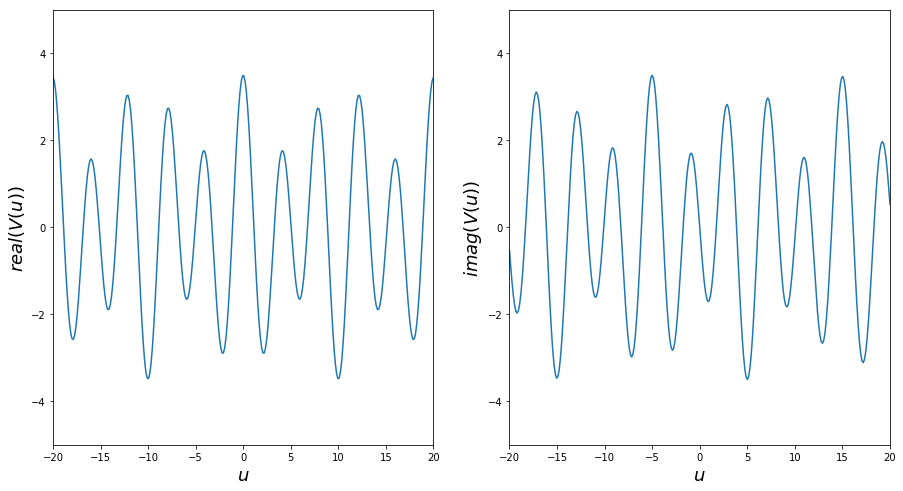

In [44]:
N = 300 # the maximum number of "baselines" that can be sampled
u = np.linspace(-20,20,N) # a grid of "baselines"

Npix = 300 # the number of "pixels" in the image
lmin = -0.5 
lmax = 0.5
l = np.linspace(lmin,lmax,Npix) # The region where we want to reconstruct the image

#deltal = l[1]-l[0]

Is1 = 1 # true flux of source one
Is2 = 2.5 # true flux of second source

# Set locations of sources (also ensuring they are at pixel centres)
l1 = l[np.argwhere(l < -0.15)[-1]]
l2 = l[np.argwhere(l < 0.25)[-1]]

# Compute the anaytic form of the visibilities
V = Is1*np.exp(-2*np.pi*1.0j*u*l1) + Is2*np.exp(-2*np.pi*1.0j*u*l2)

# Plot the visibilities
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(u,np.real(V))
ax[0].set_xlabel('$u$',fontsize=18)
ax[0].set_ylabel('$real(V(u))$',fontsize=18)
ax[0].set_xlim(-20.,20.)
ax[0].set_ylim(-5,5)

ax[1].plot(u,np.imag(V))
ax[1].set_xlabel('$u$',fontsize=18)
ax[1].set_ylabel('$imag(V(u))$',fontsize=18)
ax[1].set_xlim(-20.,20.)
ax[1].set_ylim(-5,5)

This is the theoretical signal corresponding to our sky model (over the finite domain over which we can make measurements). Unfortunately an interferometer only measures this signal at a finite number of locations in the $uv$-plane. This can be expressed mathematically by including a sampling function $S(u)$ in our measurement equation as follows

这是与我们的天空模型相对应的理论信号(在我们可以测量的有限域上)。不幸的是，干涉仪只能在$uv$-平面有限的位置测量这个信号。这可以通过在我们的测量方程中包含一个采样函数$S(u)$来用数学表示，如下所示

$$ V^{obs}(u) = S(u) \int I(l)e^{-2 \pi i ul} dl = S \mathcal{F} I, $$

where $S(u) = 1$ at locations where we have measurements and $S(u) = 0$ otherwise. This results in a discretised linear model in the same form as we have above. We are going to start by considering the noiuse free case in which all observations are equally weighted (i.e. so called naturally weighted) and give a demonstration of the effect that the weighting function has right at the end. Inverting this equation gives what is known as the dirty image $I^D$

其中在我们有测量值的位置$S(u) = 1$，否则$S(u) = 0$。这导致了一个和我们上面提到的相同形式的离散线性模型，我们将从考虑无噪声情况下开始，在这种情况下，所有的观测值都是同等加权的(即所谓的自然加权)，并给出加权函数在最后具有的效果的演示。把这个方程反过来得到脏图像I^D

$$I^D = \mathcal{F}^{-1} S \mathcal{F} I = I^{PSF} * I, \quad \mbox{where} \quad I^{PSF} = \mathcal{F}^{-1} S, $$

and we have employed the convolution theorem in the last step. From this it should be clear that the image $I^D$ reconstructed by naively applying the inverse Fourier transform to the observed visibilities $V^{obs}$ is the convolution of the true image with the point spread function (PSF) of the instrument viz. $I^{PSF}$. For this reason $I^D$ is referred to as the dirty image. Deconvolution is the process by which we attempt to remove the corrupting affects of the instrument in order to reconstruct the true image of the sky. Before we can illustrate the deconvolution process we will need to simulate this affect on our model. The code snippet below does exactly that. 

我们在最后一步中使用了卷积定理。由此可以看出，将傅里叶反变换应用于所观察到的可见度数据可以得到脏图$I^D$，重构出的图像$I^D$是真实图像与仪器的点扩展函数(PSF)的卷积。因此，$I^D$被称为脏图。反褶积一个试图消除仪器影响的过程，以重建天空的真实图像。在演示反褶积过程之前，我们需要在模型上模拟这种影响。下面的代码片段正是这样做的。

In [45]:
# Get indices at which we measure V
Nsample = 201
Sindices = np.sort(np.unique(np.random.randint(0, N, Nsample))) # unique used to ensure we dont sample any given point more than once 
Nsample = Sindices.size # true number of sampels实际的多少个采样点

# Create sampling function
S = np.zeros(N)
S[Sindices] = 1.0

# This is to compare DFT with FFT
S2 = np.ones(Nsample)
Vobs2 = V[Sindices]


# Get the observed visibilities
Vobs = np.zeros(N)
Vobs[Sindices] = V[Sindices]

# Construct FT kernel
F = np.exp(-2.0*np.pi*1.0j*np.outer(u,l))

F2 = np.exp(-2.0*np.pi*1.0j*np.outer(u[Sindices],l)) # for comparison with FFT
lpsf = np.linspace(2*lmin,2*lmax,2*N+1)
F2psf = np.exp(-2.0*np.pi*1.0j*np.outer(u[Sindices],lpsf))

# Do the iFT on S (recal FT is Hermitian FF^H = I => F^H = F^{-1})
Ipsf = np.real(np.dot(F.conj().T,S))

Ipsf2 = np.real(np.dot(F2psf.conj().T,S2)) # for comparison with FFT

# Get the dirty image
ID = np.real(np.dot(F.conj().T,Vobs))
ID2 = np.real(np.dot(F2.conj().T,Vobs2)) # for comparison with FFT


Notice that we have computed two versions of both $I^D$ and $I^{PSF}$ in the above code snippet. This is simply to illustrate the effects of aliasing when using a regular grid (as necessitated by use of the FFT algorithm). Lets first have a look at the what we would get if we sampled the visibilities on a regular grid. 

注意，在上面的代码片段中，我们已经计算了$I^D$和$I^{PSF}$的两个版本。这只是为了说明使用规则网格时混叠的效果(如使用FFT算法所必需的)。让我们首先看看如果我们在一个规则网格上采样可见性会得到什么。

(-0.5, 0.5)

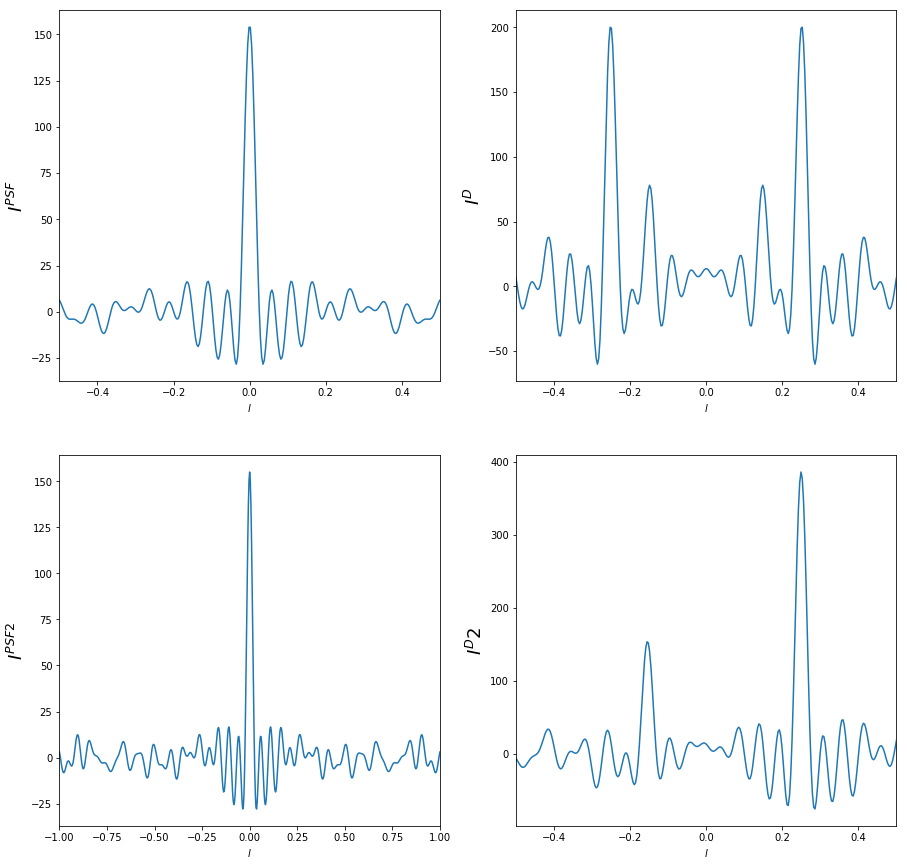

In [26]:
fig,ax = plt.subplots(nrows=2,ncols=2,figsize=(15,15))

ax[0][0].plot(l,Ipsf)
ax[0][0].set_xlabel('$l$')
ax[0][0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0][0].set_xlim(lmin,lmax)
#ax[0].set_ylim(-5,5)

ax[0][1].plot(l,ID)
ax[0][1].set_xlabel('$l$')
ax[0][1].set_ylabel('$I^D$',fontsize=18)
ax[0][1].set_xlim(lmin,lmax)
#ax[1].set_ylim(-5,5)

ax[1][0].plot(lpsf,Ipsf2)
ax[1][0].set_xlabel('$l$')
ax[1][0].set_ylabel('$I^{PSF2}$',fontsize=18)
ax[1][0].set_xlim(2*lmin,2*lmax)
#ax[2].set_ylim(-5,5)

ax[1][1].plot(l,ID2)
ax[1][1].set_xlabel('$l$')
ax[1][1].set_ylabel('$I^D2$',fontsize=18)
ax[1][1].set_xlim(lmin,lmax)
#ax[3].set_ylim(-5,5)

The figure on the left shows the PSF that results from imperfect sampling in the "$uv$-plane". We should expect to see something that resembles a sinc function (why?). On the right is the dirty "image" we would see if we did not account for aliasing. Use of the FFT inevitably requires the use of an anti-aliasing filter too. In this we get around that by using the irregularly sampled version of $V^{obs}$ (similar to using the dirct Fourier transform in imaging). The figures below show the anti-aliased version of $I^D$. Note that we have also computed $I^{PSF}$ out to double the distance as compared to $I^D$. This will be required for the deconvolution.  

左边的图显示了“$uv$-plane”中不完全采样的PSF。我们应该期望看到类似于sinc函数的东西(为什么?)右边是脏的“图像”，如果不考虑混叠，我们就会看到。使用FFT不可避免地需要使用抗混叠滤波器。我们通过使用不规则采样的$V^{obs}$(类似于在成像中使用dirct傅里叶变换)来解决这个问题。下图显示了$I^D$的抗混叠版本。注意，我们还计算了$I^{PSF}$，以便加倍$I^D$距离。对卷积来说是必需的。

(-0.5, 0.5)

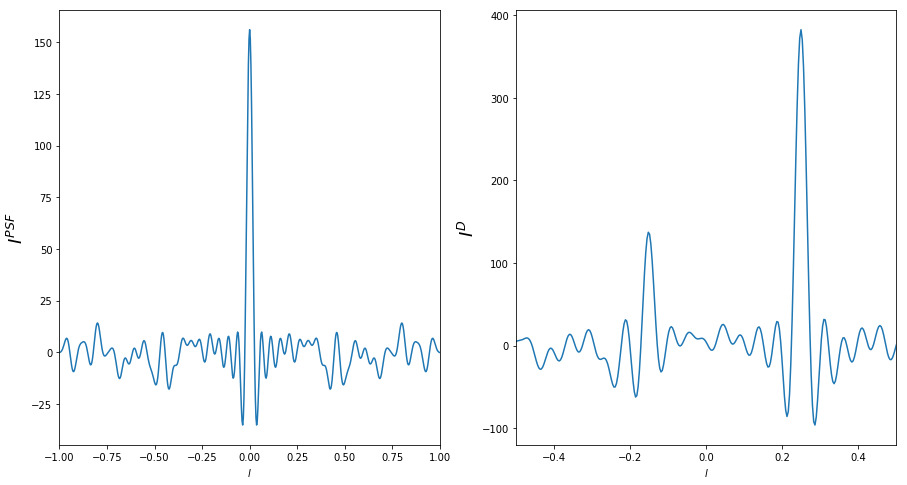

In [7]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf2)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0].set_xlim(2*lmin,2*lmax)
#ax[0].set_ylim(-5,5)

ax[1].plot(l,ID2)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^D$',fontsize=18)
ax[1].set_xlim(lmin,lmax)
#ax[1].set_ylim(-5,5)

Now there are clearly two main peaks visible in $I^{D}$ but the units seem all wrong. Normalising both by the max of the PSF we see something that is closer to the original input model. 

现在在$I^{D}$中明显有两个主要峰值，但是单位似乎都错了。通过PSF的最大值，我们可以看到一些更接近原始输入模型的东西。

(-0.5, 0.5)

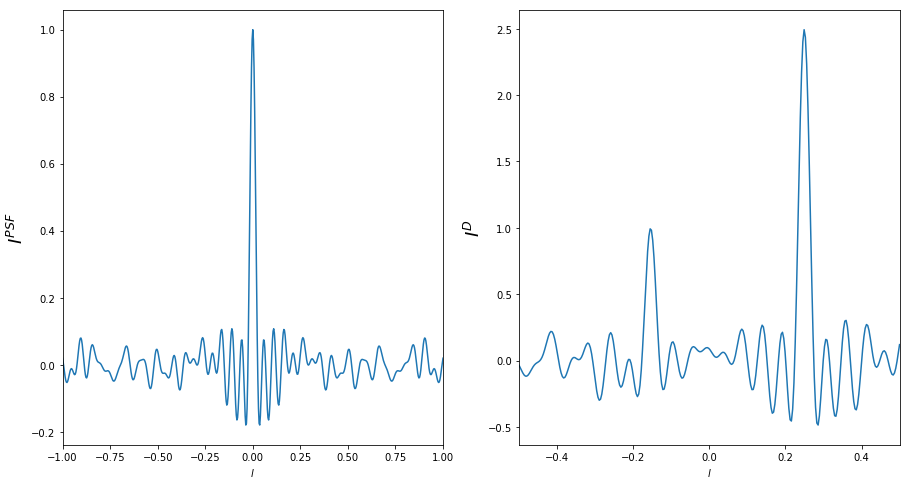

In [29]:
maxPSF = Ipsf2.max()

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf2/maxPSF)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{PSF}$',fontsize=18)
ax[0].set_xlim(2*lmin,2*lmax)


ax[1].plot(l,ID2/maxPSF)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^D$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

 We are now ready to implement the Hogbom CLEAN. The function below implements the Hogbom CLEAN algorithm in 1D.现在，我们准备实现Hogbom CLEAN。下面的函数在1D中实现了Hogbom CLEAN算法。 

In [30]:
def Hogbom_CLEAN(IR,Ipsf,gamma=0.1,tol=0.1,maxiter=200,restore=False):
    # Initialise
    i = 1
    Npix = IR.size
    Npsfmax = np.argwhere(Ipsf==1.0).squeeze()
    IM = np.zeros([Npix])
    # Find the first peak
    p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
    Ipeak = IR[p]
    while abs(Ipeak) > tol and i <= maxiter:
        # Update the residual
        IR -= gamma*Ipeak*Ipsf[Npsfmax - p:Npsfmax + Npix - p]
        # Update the sky model
        IM[p] += gamma*Ipeak
        # Find next peak
        p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
        Ipeak = IR[p]
        i += 1
        #print i, Ipeak, p
    if i >= maxiter:
        print("Warning maximum number of iterations exceeded")
    return IM, IR

Ok so lets try it out

(-0.5, 0.5)

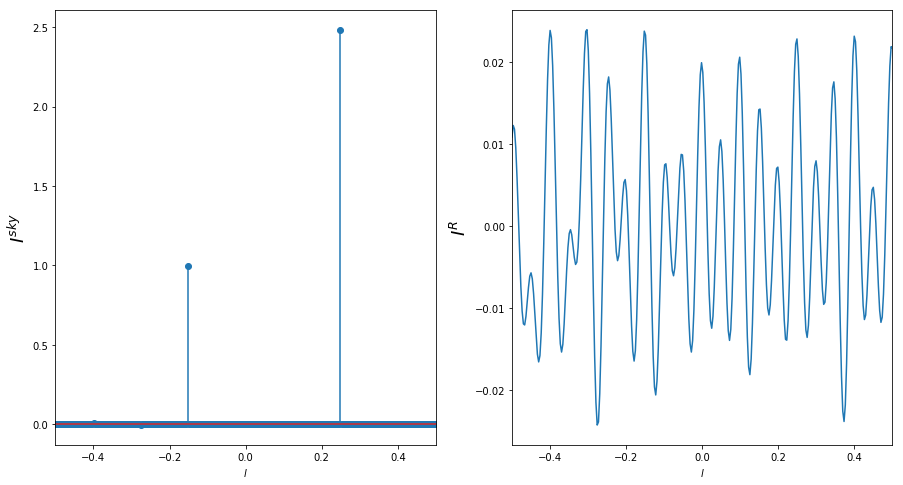

In [31]:
Ipsf = Ipsf2/maxPSF
ID = ID2/maxPSF
IM, IR = Hogbom_CLEAN(ID.copy(),Ipsf.copy(),tol=0.025)

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].stem(l,IM)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{sky}$',fontsize=18)
ax[0].set_xlim(lmin,lmax)


ax[1].plot(l,IR)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^R$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

The output above is typical of Hogbom CLEAN. ALthough it has found the peaks in approximately the right locations, sometimes the flux gets spread out over neighbouring pixels. If we were to sum the fluxes from these pixels they would add up very nearly to the input flux. This is a limitation of working exclusively in image space where discretisation errors are inevitable. The Cotton-Schwab CLEAN algorithm overcomes this by performing the subtraction in visbility space. Unfortunately switching between image and visibility space is usually the most expensive part of the algorithm. It is therefore impractical to switch between image and visibility space each time the model gets updated. Sufficient accuracy can usually be obtained by only cleaning down to 0.1 or 0.2 of the peak in the residual image during each major cycle. 

上面的输出是典型的Hogbom CLEAN。虽然它已经在大约正确的位置找到了峰值，但有时通量会分散到邻近的像素上。如果我们把这些像素的通量加起来，它们加起来几乎等于输入通量。只在图像空间中工作中，就会出现不可避免的离散化误差，这是一个限制。Cotton-Schwab Clean算法通过在可见度数据空间中执行减法来克服这个问题。不幸的是，在图像和可见空间之间切换通常是算法中最昂贵的部分。因此，每次模型更新时在图像和可见空间之间切换是不切实际的。在每个主周期内，通常只需将残差图像的峰值清除到0.1或0.2即可获得足够的精度。

In [33]:
def CS_CLEAN(Vobs, F, Ipsf, peak_Factor=0.2, maxmajoriter=10,majortol = 0.01):
    # Get max of the PSF and normalise
    maxPSF = Ipsf.max()
    Ipsf /= maxPSF 
    
    # get the dirty image and normalise
    ID = np.real(np.dot(F.conj().T,Vobs))/maxPSF
    
    # Initialise the model
    IMmajor = np.zeros_like(ID)
    
    i = 0
    IR = ID.copy()
    
    # Find the first peak
    p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
    Ipeak = IR[p]
    while abs(Ipeak) > majortol and i <= maxmajoriter:        
        # Do Hogbom step
        IM, IR = Hogbom_CLEAN(IR,Ipsf,tol=peak_Factor*Ipeak)
        
        IMmajor += IM
        
        # Evaluate the Jacobian
        Vpred = np.dot(F,IMmajor)
        Vres = Vobs - Vpred
        
        # Get new residuals and normalise by max of PSF
        IR = np.real(np.dot(F.conj().T,Vres))/maxPSF
        
        # Find the peak
        p = np.argwhere(abs(IR) == abs(IR).max()).squeeze()
        Ipeak = IR[p]  
        i += 1
        
    
    return IMmajor, IR
    

(-0.5, 0.5)

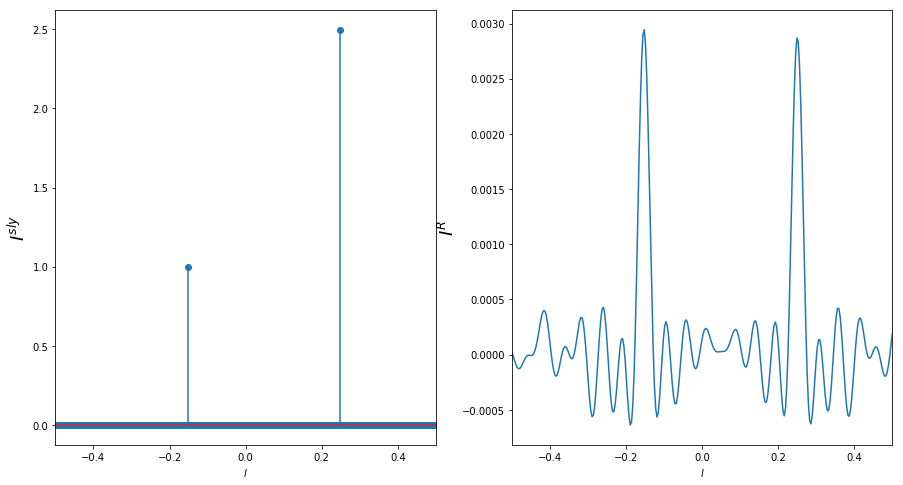

In [34]:
IM, IR = CS_CLEAN(Vobs2, F2, Ipsf2.copy())

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].stem(l,IM)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$I^{sly}$',fontsize=18)
ax[0].set_xlim(lmin,lmax)

ax[1].plot(l,IR)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^R$',fontsize=18)
ax[1].set_xlim(lmin,lmax)

Clearly the CS CLEAN does a lot better at recovering the true fluxes of the sources. We have only one job left to do and that is to create the restored image. The restored image is the model image convolved with an ideal beam (i.e. one with no sidelobes). The ideal beam can be constructed by fitting a Gaussian to the primary lobe of the PSF. 

显然，CS CLEAN在恢复源的真实通量方面做得更好。我们只剩下一项工作要做，那就是创建恢复后的映像。恢复后的图像是与理想光束(即无旁瓣)进行卷积的模型图像。通过将高斯光束拟合到PSF的主瓣上，可以构造出理想的光束

In [36]:
def Gaussian_1D(x,sigma,l):
    return sigma**2*np.exp(-x**2/(2*l**2))

def fit_Gaussian_1D(Ipsf,lpsf):
    I = np.argwhere(Ipsf > 0.5*Ipsf).squeeze()
    data = Ipsf[I]
    x = (lpsf[I])
    
    initial_guess = (1.0,0.5)
    
    popt, pcov = opt.curve_fit(Gaussian_1D, x, data, p0=initial_guess)
    Ipsf_ideal = Gaussian_1D(lpsf, *popt)
    Ipsf_ideal/=Ipsf_ideal.max()
    
    return Ipsf_ideal
    

(0, 3.5)

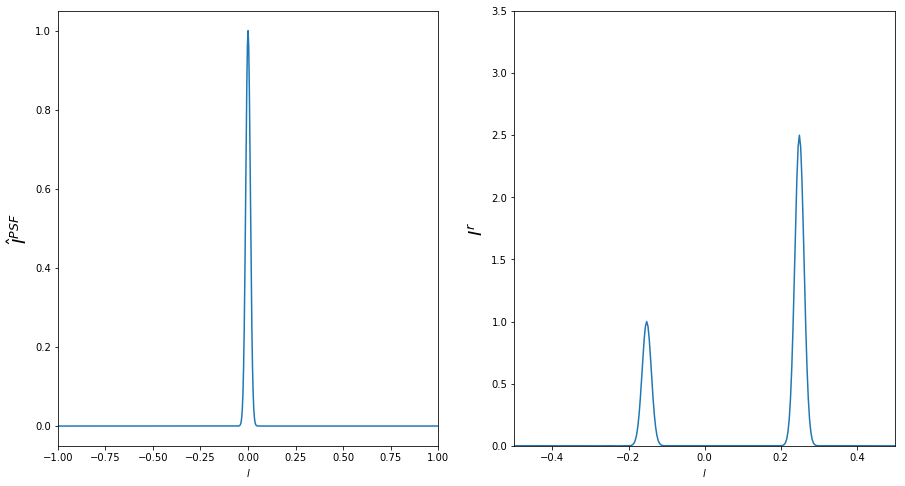

In [37]:
Ipsf_ideal = fit_Gaussian_1D(Ipsf,lpsf)

# Convolve with sky model
Irestored = scg.convolve(IM,Ipsf_ideal, mode='same')

# Add back the residuals
Irestored += IR

# Plot the results
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))

ax[0].plot(lpsf,Ipsf_ideal)
ax[0].set_xlabel('$l$')
ax[0].set_ylabel('$\hat{I}^{PSF}$',fontsize=18)
ax[0].set_xlim(-1,1)

ax[1].plot(l,Irestored)
ax[1].set_xlabel('$l$')
ax[1].set_ylabel('$I^r$',fontsize=18)
ax[1].set_xlim(lmin,lmax)
ax[1].set_ylim(0,3.5)

### 2.14.3 Weighting and the PSF

This is incomplete. I thought it might be cool to demonstrate the effect of weighting for the 1D problem. Slider controls the degree of weighting.这是不完整的。我想演示一下权重对一维问题的影响可能会很酷。滑块控制权重的大小。

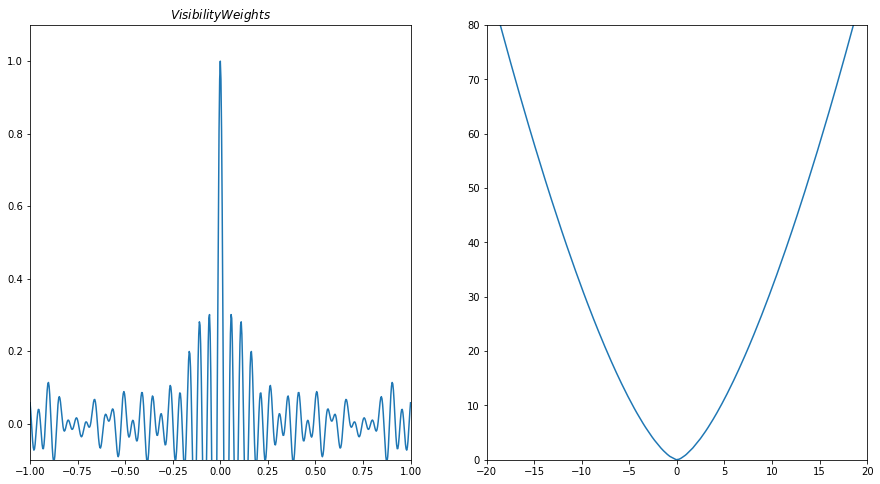

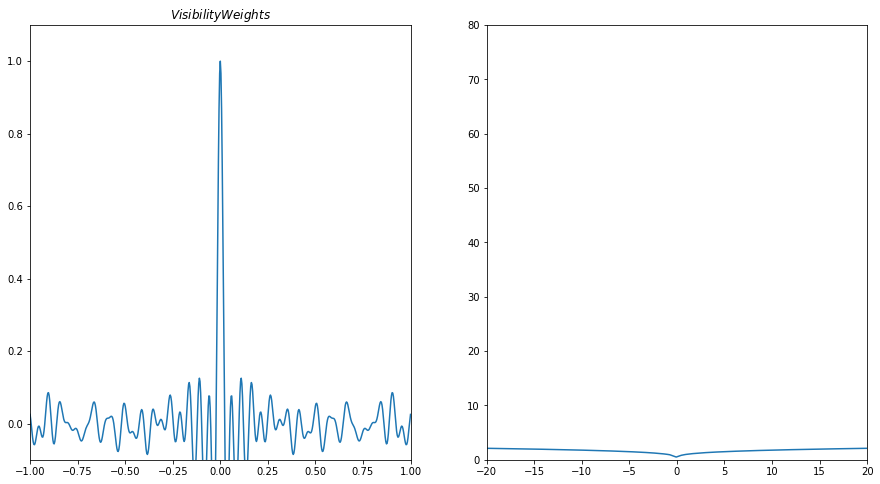

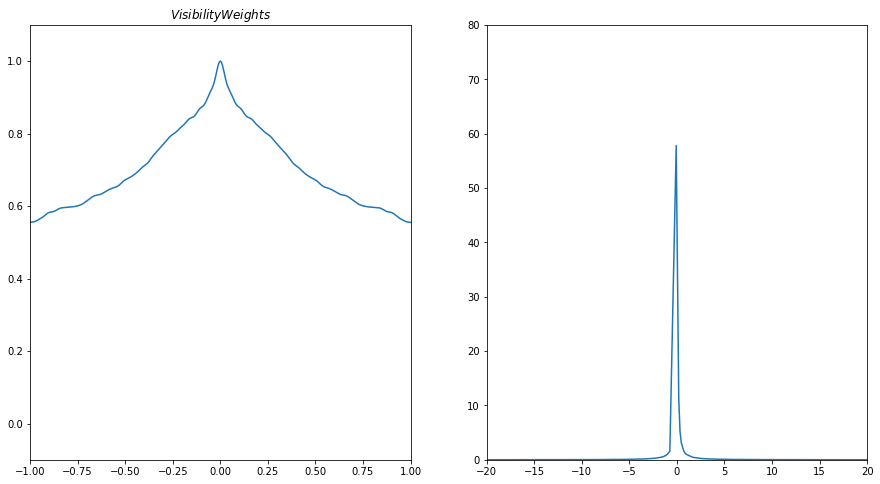

In [43]:
def inter_PSF(S,F,u,R,l):
    Ws = np.zeros(u.size)
    I = np.argwhere(u<0)
    Ws[I] = np.abs((-u[I])**R)
    I = np.argwhere(u>=0)
    Ws[I] = np.abs(u[I]**R)
    Ipsf = np.real(np.dot(F.conj().T,S*Ws))
    Ipsf /= Ipsf.max()
    fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15,8))
    ax[0].plot(l,Ipsf)
    ax[0].set_xlim(-1,1)
    ax[0].set_ylim(-0.1,1.1)
    ax[0].set_title(r'$PSF$')
    ax[1].plot(u,Ws)
    ax[1].set_xlim(-20,20)
    ax[1].set_ylim(0,80)
    ax[0].set_title(r'$Visibility Weights$')
R = 1.5   
inter_PSF(S=S2,F=F2psf,u=u[Sindices],R=R,l=lpsf)
R = 0.25   
inter_PSF(S=S2,F=F2psf,u=u[Sindices],R=R,l=lpsf)
R = -1.5   
inter_PSF(S=S2,F=F2psf,u=u[Sindices],R=R,l=lpsf)

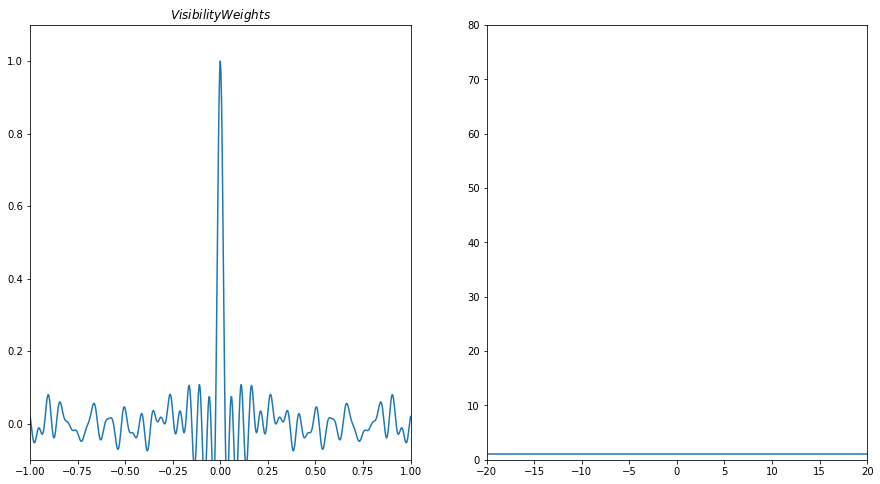

In [39]:
interact(lambda R:inter_PSF(S=S2,F=F2psf,u=u[Sindices],R=R,l=lpsf),
                R=(-1.5,1.5,0.25)) and None

***

Next: [2.x Further Reading and References](2_x_further_reading_and_references.ipynb)